<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [292]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import re
import pandas as pd 
import time

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score, classification_report
import scikitplot as skplt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [293]:
"""Convert HTML into beautiful soup"""
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [3]:
def extract_salary(result):
    salary=[]
    for i in result.find_all('div',attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            salary.append(i.find('span',attrs={'class':'salaryText'}).text.strip())
        except:
            salary.append(np.nan)
    return salary

In [4]:
def extract_title(result):
    title=[]
    for i in result.find_all('div',attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            title.append(i.find('div',attrs={'class':'title'}).text.strip())
        except:
            title.append(np.nan)
    return title

In [5]:
def extract_company(result):
    company=[]
    for i in result.find_all('div',attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            company.append(i.find('span',attrs={'class':'company'}).text.strip())
        except:
            company.append(np.nan)
    return company

In [396]:
def extract_summary(result):
    location=[]
    try:
        for i in result.find_all('div',attrs={'class':'summary'}):
            location.append(i.text.strip())
    except:
        location.append(np.nan)
            
    return location

In [397]:
def extract_location(result):
    location=[]
    try:
        for i in result.find_all(['div','span'],attrs={'class':'location accessible-contrast-color-location'}):
            location.append(i.text.strip())
    except:
        location.append(np.nan)
            
    return location

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

# Web Scraping

To maximise number of adverts listing salaries, I cast a wide net over the UK with each city having a search radius of 10 miles. This will increase the chance of duplicate entries from cities close to each other, but this will be dealt with later. The first block collates the number of hits per city to use in the actual scraping to increase efficiency- the scrape will only loop as many times as there is actual jobs in that city

In [402]:
#UK
max_city={}
for city in set(['London', 'Edinburgh', 'Manchester', 'Newcastle', 'Liverpool', 
    'Glasgow',  'Belfast', 'Cardiff', 
    'Bristol', 'Exeter', 'York', 'Leeds', 'Birmingham', 'Southampton','Oxford','Cambridge',
    'Swindon','Brighton','Aberdeen','Bradford','Sheffield','Sunderland',
    'Reading','Guildford','Stirling','Coventry','Nottingham','Leicester',
     'Slough','Durham','Derby','Stirling','Dundee','Carlisle','Portsmouth','Bournemouth','Plymouth',
     'Canterbury','Ipswich','Norwich','Chelmsford','Colchester','Stoke','Bolton','Blackburn',
    'Wigan','Inverness','Hull','Lancaster','St Andrews','Swindon','Bath','Swansea','Northampton','Worcester',
    'Watford','Milton Keynes','Coventry','Warwick','Coleraine','Wrexham','Lisburn','Paisley','Motherwell',
    'Falkirk','Dartford','Dover','Stevenage','St Albans','Luton','Basildon','Harlow','Aldershot','Doncaster','Peterborough']):
    URL="https://www.indeed.co.uk/jobs?q=Data+%2B+Science+or+Data+%2BEngineer+or+Data+%2BArchitect+or+Data%2B+Analyst+%C2%A320000&l=%7B{}%7D&radius=10".format(city)
    r = requests.get(URL)
        
    soup = BeautifulSoup(r.text, 'html.parser')

    count=[i.text.strip() for i in soup.find_all('div',attrs={'id':'searchCountPages'})]
    pattern = re.compile(r'[\S]?[\d]+')
    try:
        page=re.findall(pattern, count[0])
        try:
            number=page[1]+page[2]
            number=number.replace(',','')
            number=int(number)
        except:
            number=page[1]
    except:
        number=0
    max_city[city]=number

In [403]:

company=[]
salary=[]
location=[]
title=[]
sumy=[]

for city in set(['London', 'Edinburgh', 'Manchester', 'Newcastle', 'Liverpool', 
    'Glasgow',  'Belfast', 'Cardiff', 
    'Bristol', 'Exeter', 'York', 'Leeds', 'Birmingham', 'Southampton','Oxford','Cambridge',
    'Swindon','Brighton','Aberdeen','Bradford','Sheffield','Sunderland',
    'Reading','Guildford','Stirling','Coventry','Nottingham','Leicester',
     'Slough','Durham','Derby','Stirling','Dundee','Carlisle','Portsmouth','Bournemouth','Plymouth',
     'Canterbury','Ipswich','Norwich','Chelmsford','Colchester','Stoke','Bolton','Blackburn',
    'Wigan','Inverness','Hull','Lancaster','St Andrews','Swindon','Bath','Swansea','Northampton','Worcester',
    'Watford','Milton Keynes','Coventry','Warwick','Coleraine','Wrexham','Lisburn','Paisley','Motherwell',
    'Falkirk','Dartford','Dover','Stevenage','St Albans','Luton','Basildon','Harlow','Aldershot','Doncaster','Peterborough']):
    print(city + ' starting (' +str(max_city[city]) + ' searches)')
    for start in range(0, int(max_city[city]), 10):
        URL="https://www.indeed.co.uk/jobs?q=Data+%2B+Science+or+Data+%2BEngineer+or+Data+%2BArchitect+or+Data%2B+Analyst+%C2%A320000&l=%7B{}%7D&radius=10&start={}".format(city,start)
        r = requests.get(URL)
        
        soup = BeautifulSoup(r.text, 'html.parser')
        c=extract_company(soup)
        for comp in c:
            company.append(comp)
        s=extract_salary(soup)
        for sal in s:
            salary.append(sal)
        l=extract_location(soup)
        for loc in l:
            location.append(loc)
        t=extract_title(soup)
        for tit in t:
            title.append(tit)
        su=extract_summary(soup)
        index= city + ': ' + str(start)
        for sums in su:
            sumy.append(sums)
        # Append to the full set of results
        time.sleep(0.5)
    time.sleep(1)
    print(city + ' complete')

    



Hull starting (19 searches)
Hull complete
Lisburn starting (191 searches)
Lisburn complete
Dover starting (4 searches)
Dover complete
Brighton starting (94 searches)
Brighton complete
Bradford starting (301 searches)
Bradford complete
Stirling starting (6 searches)
Stirling complete
Watford starting (183 searches)
Watford complete
Cambridge starting (116 searches)
Cambridge complete
Leicester starting (68 searches)
Leicester complete
Milton Keynes starting (98 searches)
Milton Keynes complete
Nottingham starting (84 searches)
Nottingham complete
Blackburn starting (48 searches)
Blackburn complete
Bournemouth starting (78 searches)
Bournemouth complete
Motherwell starting (4 searches)
Motherwell complete
Aldershot starting (98 searches)
Aldershot complete
Chelmsford starting (28 searches)
Chelmsford complete
Bolton starting (77 searches)
Bolton complete
Bath starting (50 searches)
Bath complete
Northampton starting (48 searches)
Northampton complete
Swansea starting (12 searches)
Swanse

In [406]:
job_search=pd.DataFrame({'Title':title,
                     'Summary':sumy,
                     'Location':location,
                     'Company':company,
                     'Salary': salary})
#job_search.to_csv('UK_data3.csv')


# EDA and feature engineering 

In [302]:
job_search=pd.read_csv('UK_data3.csv')
job_search.drop('Unnamed: 0',axis=1,inplace=True)

In [303]:
#Remove job adverts that don't list a salary and drop duplicate entries
job_search.dropna(inplace=True)
job_search.drop_duplicates(keep='first',inplace=True,subset=['Title','Company','Location'])
job_search.reset_index(drop=True,inplace=True)

In [304]:
 #Regex to remove postcodes from cities to allow for easier location finding
def postcode_remove(x):   
    hold=[]

    try:
        pattern=re.compile(r'\w{1,2}\d{1,2}\w{0,1}')
        pcode=re.findall(pattern,x)
        code=' ' + pcode[0]
        j=x.replace(code,'')
        hold.append(str(j))
    except:
        hold.append(x)
    return hold

        

In [305]:
#If job location listed in one of the following cities, state that city as its location
top_city=['London','Manchester','Leeds','Bristol','Birmingham','Reading','Milton Keynes','Cardiff','Edinburgh','Newcastle upon Tyne','Glasgow','Watford','Oxford','Belfast','Coventry','Cambridge']
def city_sort(x):
    cities=[]
    for city in top_city:
        if city in x:
            cities.append(city)

            
    return cities
            

In [306]:
#Regex to take salaries in yearly or montly format and returns in float value
def salary_find(x):
    moolah=[]
    if 'year' in x:
        pattern = re.compile(r'\d{1,3},\d{1,3}')
        numb=re.findall(pattern, x)
        if len(numb)>1:  
            count=0
            for i in numb:
                i=i.replace(',','')
                i=int(i)
                count+=i
            av=float(count/2)
            moolah.append(av)
        else:
            dosh=numb[0].replace(',','')
            dosh=int(dosh)
            moolah.append(dosh)
    elif 'month' in x:
        pattern=re.compile(r'\d{1,3},\d{1,3}')
        num=re.findall(pattern,x)
        num=num[0].replace(',','')
        num=int(num)*12
        moolah.append(num)
        
    else:
        moolah.append(np.nan)
    return moolah

In [307]:
job_search['Location']=job_search.Location.map(postcode_remove).str[0]

In [308]:
#If location is Nan from city_sort function, then replace with 'Rest of UK'
job_search['City']=job_search.Location.map(city_sort).str[0]
job_search.City.fillna('Rest of UK',inplace=True)
job_search['Sal']=job_search.Salary.map(salary_find).str[0]

job_search.reset_index(drop=True,inplace=True)

In [309]:
job_search.dropna(inplace=True)
job_search.reset_index(drop=True,inplace=True)

In [314]:
#Create target variable where jobs with salary greater than median listed as 1
median=job_search.Sal.median()
def high_low(x):
    med=[]
    if x > median:
        med.append(1)
    else:
        med.append(0)
    return med
    

In [415]:
median

35000.0

In [ ]:
job_search['Pay']=job_search.Sal.map(high_low).str[0]

In [315]:
#Calculate baseline
baseline=job_search.Pay.value_counts(normalize=True).max()
baseline

0.5366391184573003

In [316]:
#Further feature engineering, create categories if any of the following words appear in job title
entry_job=['Junior','Graduate','Trainee','Apprentice']
senior_job=['Senior','Fellow','Master','Lead','Chief','Manager','Snr','Principle','Supervisor','Executive','Principal']
temp_job=['Interim','12 months','Part-Time','Temporary']

In [317]:
def job_dummy(x,job_type):
    output=[]
    count=0
    for i in job_type:       
        if i.upper() in x.upper():
            count+=1
    if count>0:
        output.append(1)
    else:
        output.append(0)
    return output

In [318]:
#Feature to differentiate between jobs paid on annual or monthly salary
job_search['Annual']=job_search.Salary.apply(lambda x: 1 if 'year' in x else 0)

In [319]:
job_search['entry_job']=job_search.Title.apply(job_dummy,job_type=entry_job).str[0]
job_search['senior_job']=job_search.Title.apply(job_dummy,job_type=senior_job).str[0]
job_search['temp_job']=job_search.Title.apply(job_dummy,job_type=temp_job).str[0]



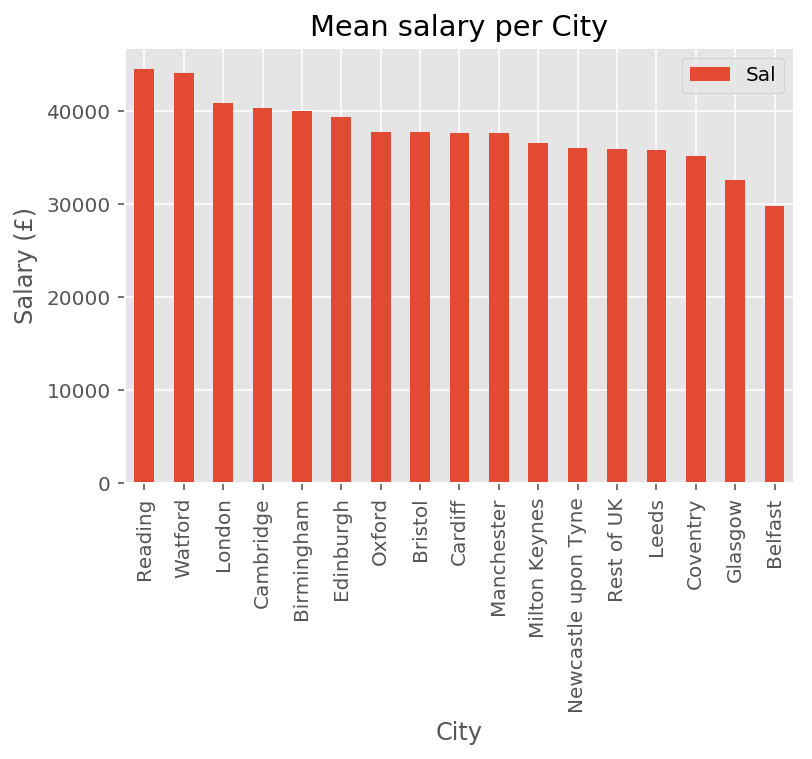

In [320]:
#Show average salary per city
pd.DataFrame(round(job_search.groupby('City')['Sal'].mean(),2)).sort_values(by='Sal',ascending=False).plot(kind='bar')
plt.title('Mean salary per City')
plt.ylabel('Salary (£)')
plt.show()

In [ ]:
job_search.to_csv('UK_data_cleaned3.csv')

In [321]:
#Dummify City column so location can be used as a predictor
job_search=pd.read_csv('UK_data_cleaned3.csv')
job_search.drop('Unnamed: 0',axis=1,inplace=True)
job_search=pd.get_dummies(job_search,columns=['City'],drop_first=False)


In [322]:
#Create predictor dataframe
X=job_search.drop(['Title','Location','Company','Salary','Sal','Pay', 'City_Rest of UK'],axis=1)

In [323]:
#Target vector
y=job_search.pop('Pay')

# Modelling

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=29, train_size=0.8)

In [335]:
#Use NLP on summary column
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tvec = TfidfVectorizer(stop_words='english',ngram_range=(1,2),min_df=0.01)
tvec.fit(X_train.Summary);

In [336]:
cvec = CountVectorizer(token_pattern='\w+',stop_words='english',min_df=0.01,ngram_range=(1,2))
cvec.fit(X_train.Summary);

The following code is exploratory modelling- I will compare different NLP processes against different classification models to see which returns the best accuracy against the baseline

In [337]:
tvec_train = pd.DataFrame(tvec.transform(X_train.Summary).toarray(),
                  columns=tvec.get_feature_names())

tvec_test = pd.DataFrame(tvec.transform(X_test.Summary).toarray(),
                  columns=tvec.get_feature_names())
cvec_train = pd.DataFrame(tvec.transform(X_train.Summary).toarray(),
                  columns=tvec.get_feature_names())

cvec_test = pd.DataFrame(tvec.transform(X_test.Summary).toarray(),
                  columns=tvec.get_feature_names())

In [338]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)


In [339]:
t_train=pd.merge(X_train,tvec_train,left_index=True,right_index=True)
t_test=pd.merge(X_test,tvec_test,left_index=True,right_index=True)
c_train=pd.merge(X_train,cvec_train,left_index=True,right_index=True)
c_test=pd.merge(X_test,cvec_test,left_index=True,right_index=True)

In [340]:
t_train.drop('Summary',axis=1,inplace=True)
t_test.drop('Summary',axis=1,inplace=True)
c_train.drop('Summary',axis=1,inplace=True)
c_test.drop('Summary',axis=1,inplace=True)
X_train.drop('Summary',axis=1,inplace=True)
X_test.drop('Summary',axis=1,inplace=True)

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [341]:
nlp_train={'cvec':c_train,'tvec':t_train,'none':X_train}
nlp_test={'cvec':c_test,'tvec':t_test,'none':X_test}


In [342]:
options=['lr','lrcv','knn','dct','svc','rfc','etc']

In [343]:
models={'lr':LogisticRegression(),
       'lrcv':LogisticRegressionCV(),
       'knn':KNeighborsClassifier(),
       'dct':DecisionTreeClassifier(),
       'svc':SVC(),
       'rfc':RandomForestClassifier(),
       'etc':ExtraTreesClassifier()}

In [344]:
standard=[PolynomialFeatures()]


In [346]:
test_scores=[]
mod=[]
nlps=[]
for nlp in ['cvec','tvec','none']:
    for i in options:
        classify=models[i].fit(nlp_train[nlp],y_train)
        cross=cross_val_score(models[i], nlp_train[nlp],y_train, cv=5)
        print( nlp + ' + ' + i)
        test_scores.append(classify.score(nlp_test[nlp],y_test))
        mod.append(i)
        nlps.append(nlp)
        print('Baseline Accuracy: ' + str(baseline))
        print('Train Accuracy: ' + str(classify.score(nlp_train[nlp],y_train)))
        print('CV Accuracy: ' + str(cross.mean()))
        print('Test Accuracy: ' + str(classify.score(nlp_test[nlp],y_test)))
pd.DataFrame({'model':mod,'test_score':test_scores,'nlp':nlps}).sort_values(by='test_score',ascending=False)

cvec + lr
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.7617079889807162
CV Accuracy: 0.6570280838961962
Test Accuracy: 0.7052341597796143


/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

cvec + lrcv
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.7128099173553719
CV Accuracy: 0.6391112691077142
Test Accuracy: 0.6887052341597796
cvec + knn
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.7658402203856749
CV Accuracy: 0.6184642730181301
Test Accuracy: 0.6776859504132231
cvec + dct
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.993801652892562
CV Accuracy: 0.6047304182960067
Test Accuracy: 0.6584022038567493
cvec + svc
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.796831955922865
CV Accuracy: 0.6494323972034601
Test Accuracy: 0.696969696969697
cvec + rfc
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.993801652892562
CV Accuracy: 0.6618533001540468
Test Accuracy: 0.6859504132231405
cvec + etc
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.993801652892562
CV Accuracy: 0.64461903069084
Test Accuracy: 0.6721763085399449
tvec + lr
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.7617079889807162
CV Accuracy: 0.65702808

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

tvec + lrcv
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.7128099173553719
CV Accuracy: 0.6391112691077142
Test Accuracy: 0.6887052341597796
tvec + knn
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.7658402203856749
CV Accuracy: 0.6184642730181301
Test Accuracy: 0.6776859504132231
tvec + dct
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.993801652892562
CV Accuracy: 0.5950776158312597
Test Accuracy: 0.6446280991735537
tvec + svc
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.796831955922865
CV Accuracy: 0.6494323972034601
Test Accuracy: 0.696969696969697
tvec + rfc
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.993801652892562
CV Accuracy: 0.6425832444602442
Test Accuracy: 0.6556473829201102
tvec + etc
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.993801652892562
CV Accuracy: 0.6432373503969664
Test Accuracy: 0.696969696969697
none + lr
Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.6391184573002755
CV Accuracy: 0.6260125

,model,test_score,nlp
0,lr,0.705234,cvec
7,lr,0.705234,tvec
13,etc,0.696970,tvec
11,svc,0.696970,tvec
4,svc,0.696970,cvec
1,lrcv,0.688705,cvec
8,lrcv,0.688705,tvec
5,rfc,0.685950,cvec
9,knn,0.677686,tvec
2,knn,0.677686,cvec


A Logistic Regression model with either NLP process returns the best accuracy on the training score, so will carry this model on forward. 

Next I will investigate Polynomial features to see if including interactions improves the accuracy

In [60]:
lr_poly_pipe=Pipeline([('scaler', PolynomialFeatures(degree=2)),
                    ('model', LogisticRegression())])

In [61]:
for nlp in ['cvec','tvec']:
    poly_class=lr_poly_pipe.fit(nlp_train[nlp],y_train)
    print (nlp)
    cross=cross_val_score(LogisticRegression(), nlp_train[nlp],y_train, cv=5)
    print('Baseline Accuracy: ' + str(baseline))
    print('Train Accuracy: ' + str(poly_class.score(nlp_train[nlp],y_train)))
    print('CV Accuracy: ' + str(cross.mean()))
    print('Test Accuracy: ' + str(poly_class.score(nlp_test[nlp],y_test)))
    

cvec
Baseline Accuracy: 0.5999048525214081
Train Accuracy: 0.878099173553719
CV Accuracy: 0.6570280838961962
Test Accuracy: 0.6859504132231405
tvec
Baseline Accuracy: 0.5999048525214081
Train Accuracy: 0.878099173553719
CV Accuracy: 0.6570280838961962
Test Accuracy: 0.6859504132231405


It does not.

Best accuracy is still on Logistic Regression with accuracy of 0.705.

Now I will try different ensemble methods to see which returns best accuracy. The best one will be entered into a grid search to optimise hyper parameters

In [255]:
ensembles={'ada':AdaBoostClassifier(base_estimator=LogisticRegression()),
           'bag':BaggingClassifier(base_estimator=LogisticRegression()),
           'gb':GradientBoostingClassifier()}

In [269]:
for i in ['cvec','tvec']:
    for ens in ['ada','bag','gb']:
        model=ensembles[ens].fit(nlp_train[i],y_train)
        print (i + ' + ' + ens)
        cross=cross_val_score(ensembles[ens], nlp_train[nlp],y_train, cv=5)
        print('Baseline Accuracy: ' + str(baseline))
        print('Train Accuracy: ' + str(model.score(nlp_train[nlp],y_train)))
        print('CV Accuracy: ' + str(cross.mean()))
        print('Test Accuracy: ' + str(model.score(nlp_test[nlp],y_test)))

cvec + ada
Baseline Accuracy: 0.5999048525214081
Train Accuracy: 0.6377410468319559
CV Accuracy: 0.6301433819172887
Test Accuracy: 0.6639118457300276
cvec + bag
Baseline Accuracy: 0.5999048525214081
Train Accuracy: 0.7472451790633609
CV Accuracy: 0.6515203223130703
Test Accuracy: 0.6914600550964187
cvec + gb
Baseline Accuracy: 0.5999048525214081
Train Accuracy: 0.8353994490358126
CV Accuracy: 0.6529043725559901
Test Accuracy: 0.6721763085399449
tvec + ada
Baseline Accuracy: 0.5999048525214081
Train Accuracy: 0.6377410468319559
CV Accuracy: 0.6301433819172887
Test Accuracy: 0.6639118457300276
tvec + bag
Baseline Accuracy: 0.5999048525214081
Train Accuracy: 0.743801652892562
CV Accuracy: 0.6590851996682072
Test Accuracy: 0.6914600550964187
tvec + gb
Baseline Accuracy: 0.5999048525214081
Train Accuracy: 0.8326446280991735
CV Accuracy: 0.6515155824149781
Test Accuracy: 0.6639118457300276


Bagging classifier with either NLP process is best, therefore I will Gridsearch on a bagging classifier with a logistic regression base estimator to see if accuracy can be improved.

In [150]:
BaggingClassifier(base_estimator=LogisticRegression()).get_params()

{'base_estimator__C': 1.0,
 'base_estimator__class_weight': None,
 'base_estimator__dual': False,
 'base_estimator__fit_intercept': True,
 'base_estimator__intercept_scaling': 1,
 'base_estimator__l1_ratio': None,
 'base_estimator__max_iter': 100,
 'base_estimator__multi_class': 'auto',
 'base_estimator__n_jobs': None,
 'base_estimator__penalty': 'l2',
 'base_estimator__random_state': None,
 'base_estimator__solver': 'lbfgs',
 'base_estimator__tol': 0.0001,
 'base_estimator__verbose': 0,
 'base_estimator__warm_start': False,
 'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_j

In [365]:
lr_params={'base_estimator__penalty':['l1','l2'],
           'base_estimator__solver':['liblinear'],
           'base_estimator__C':[1.0,10,100],
           'base_estimator__max_iter':[100,1000],
           'n_estimators':[10,100,200],
           'random_state':[None, 29]}
model=BaggingClassifier(base_estimator=LogisticRegression())
lr_grid=GridSearchCV(model,
                     lr_params,
                     n_jobs=2, 
                     cv=5, 
                     verbose=1, 
                     return_train_score=True).fit(c_train,y_train)
best=lr_grid.best_estimator_
print('Baseline Accuracy: ' + str(baseline))
print('Train Accuracy: ' + str(best.score(c_train,y_train)))
print('Test Accuracy: ' + str(best.score(c_test,y_test)))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   36.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed: 29.1min finished


Baseline Accuracy: 0.5366391184573003
Train Accuracy: 0.756198347107438
Test Accuracy: 0.7079889807162535


It does! By 0.002! This is the best model I have produced so far in terms of accuracy, so lets look the most influential features in determing whether the model will correctly predict salary level

In [394]:
model_coeff = np.mean([lr.coef_ for lr in best.estimators_], axis=0)
coeff_magnitude = np.std(c_train, 0) * model_coeff[0]

In [395]:
effects=pd.DataFrame({'Feature':c_train.columns,
              'Effect':[i for i in coeff_magnitude]})
effects['Absolute']=np.abs(effects.Effect)
effects.sort_values(by='Absolute',ascending=False).head(10)

,Feature,Effect,Absolute
2,senior_job,0.508777,0.508777
1,entry_job,-0.437902,0.437902
13,City_London,0.334189,0.334189
65,business analyst,0.190324,0.190324
64,business,0.146637,0.146637
5,City_Birmingham,0.139594,0.139594
18,City_Reading,0.127659,0.127659
294,support,-0.098576,0.098576
14,City_Manchester,0.098493,0.098493
143,financial,0.093770,0.093770


Unsurprisingly, whether the job is listed as entry or senior has the largest effect on whether a job is high paying or not. This is followed by the job being in London, again unsurprising. 

Now, lets look at the confusion matrix to make sense of how the model is performing in predicting accurately which categories jobs fall in

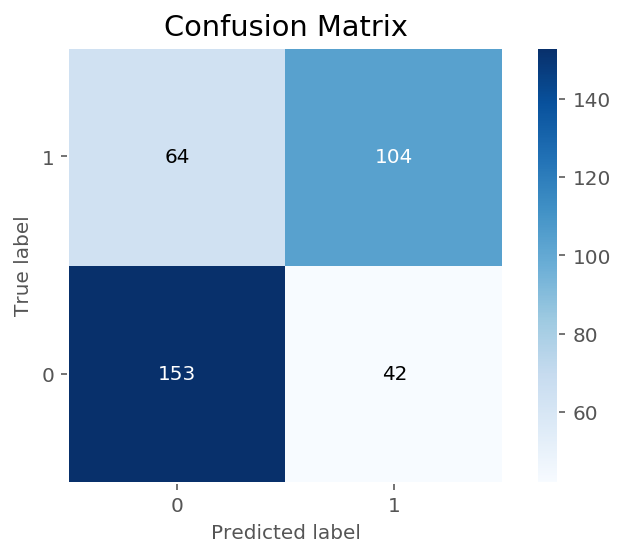

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       195
           1       0.71      0.62      0.66       168

    accuracy                           0.71       363
   macro avg       0.71      0.70      0.70       363
weighted avg       0.71      0.71      0.71       363



In [347]:
predictions=best.predict(c_test)
probabilities=best.predict_proba(c_test)
skplt.metrics.plot_confusion_matrix(y_test, predictions)
plt.ylim([-0.5, len(y_test.unique())-0.5])
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test,predictions))


The model is ok so far, with the True Positives and True Negatives out doing the False equivalents. The Precision is good, but it can be better.

My boss's brief was to avoid falsely telling candidates they have a high paying salary, so I need to adjust the model threshold to maximise precision while hopefully not destroying the recall

In [348]:
Y_pp = pd.DataFrame(probabilities, 
             columns=['class_0_pp', 'class_1_pp'])
scores_test = scores_at_thresholds(Y_pp.class_1_pp,y_test)

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

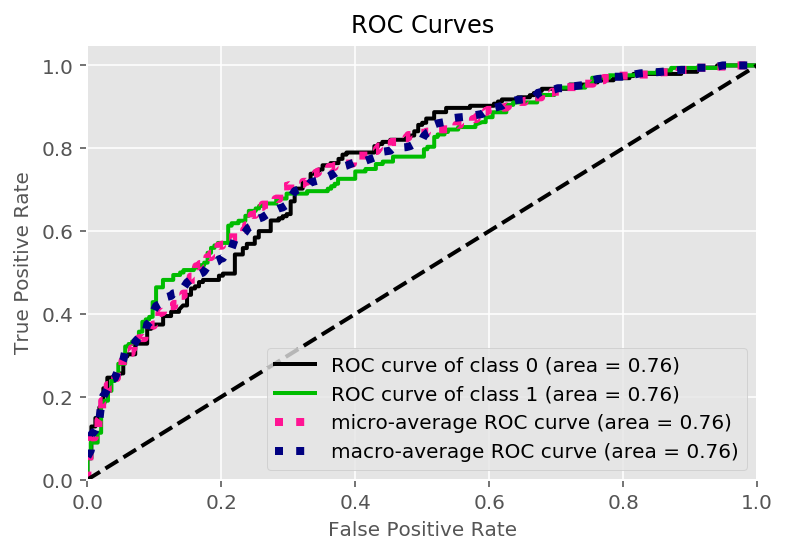

In [164]:
skplt.metrics.plot_roc(y_test, probabilities)
plt.show()

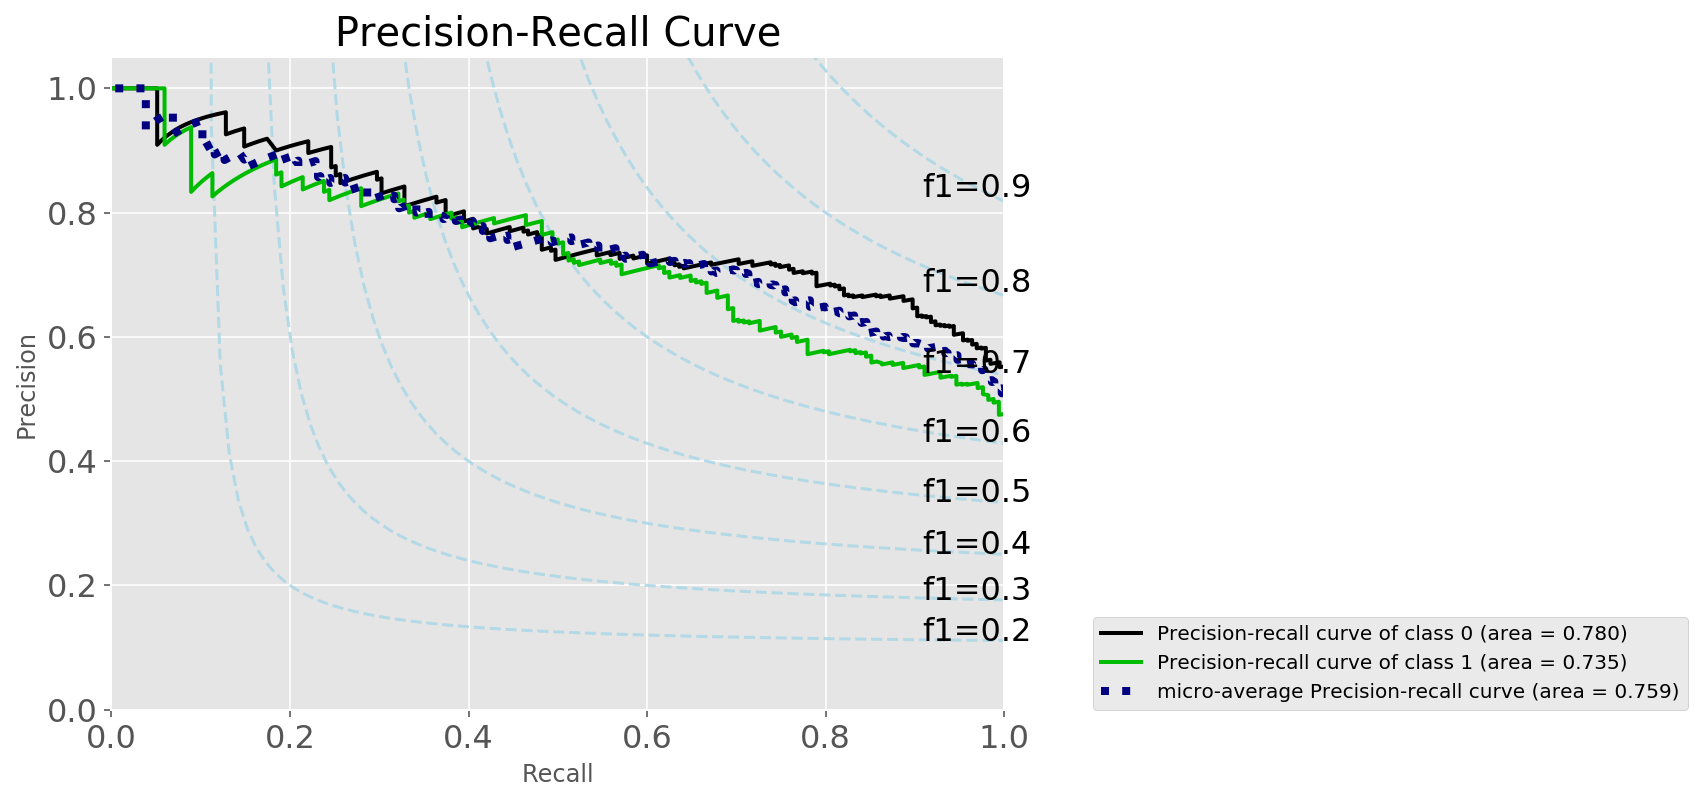

In [165]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

In [106]:
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0a
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def scores_at_thresholds(probs,y):
    predictions = [probs.apply(predict_at_threshold, threshold=i) 
                   for i in np.linspace(0, 1, 1000)]
    scores = np.array(
    [(threshold, 
      accuracy_score(y, predictions[i]),
      precision_score(y, predictions[i]),
      recall_score(y, predictions[i]), 
      f1_score(y, predictions[i])) 
     for i, threshold in enumerate(np.linspace(0, 1, 1000))])
    return scores

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     Threshold  Accuracy    Recall  Precision        f1
500   0.500501  0.707989  0.619048   0.712329  0.662420
503   0.503504  0.707989  0.619048   0.712329  0.662420
502   0.502503  0.707989  0.619048   0.712329  0.662420
501   0.501502  0.707989  0.619048   0.712329  0.662420
499   0.499499  0.707989  0.619048   0.712329  0.662420
498   0.498498  0.707989  0.619048   0.712329  0.662420
476   0.476476  0.705234  0.660714   0.689441  0.674772
485   0.485485  0.705234  0.636905   0.699346  0.666667
484   0.484484  0.705234  0.636905   0.699346  0.666667
483   0.483483  0.705234  0.636905   0.699346  0.666667
482   0.482482  0.705234  0.648810   0.694268  0.670769
481   0.481481  0.705234  0.648810   0.694268  0.670769
480   0.480480  0.705234  0.654762   0.691824  0.672783
479   0.479479  0.705234  0.654762   0.691824  0.672783
478   0.478478  0.705234  0.660714   0.689441  0.674772
477   0.477477  0.705234  0.660714   0.689441  0.674772
497   0.497497  0.705234  0.619048   0.707483  0

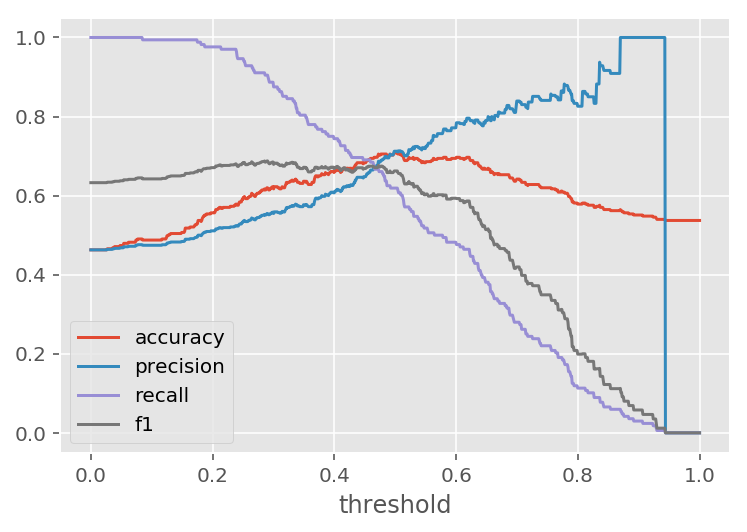

In [398]:
thres=[]
acc=[]
recall=[]
pres=[]
f1=[]
for threshold in np.linspace(0,1,1000):
    preds=Y_pp.class_1_pp.apply(predict_at_threshold, 
                                                threshold=threshold)
    thres.append(threshold)
    acc.append(accuracy_score(y_test,preds))
    recall.append(recall_score(y_test,preds))
    pres.append(precision_score(y_test,preds))
    f1.append(f1_score(y_test,preds))

print(pd.DataFrame({'Threshold':thres,
              'Accuracy':acc,
              'Recall':recall,
              'Precision':pres,
              'f1':f1}).sort_values(by='Accuracy',ascending=False).head(20))
plt.plot(scores_test[:, 0], scores_test[:, 1], label='accuracy')
plt.plot(scores_test[:, 0], scores_test[:, 2], label='precision')
plt.plot(scores_test[:, 0], scores_test[:, 3], label='recall')
plt.plot(scores_test[:, 0], scores_test[:, 4], label='f1')
plt.legend()
plt.xlabel('threshold')
plt.show()

From the ROC curves I can see that aiming for a higher True Positive rate will result in more False positives which I want to avoid- therefore, to minimise false positives we will have to accept a loss in true positives, therefore an increase in false negatives.

The Precision- Recall curve shows an increase in recall will lead to a reduction in precision, which I want to maximise. Therefore, an increase in precision will make recall worse.

The final graph shows that an ideal threshold to achieve my stated aims would likely be in thr region of 0.7 plus. I have experimented with several values, and the one I think matches the brief most is displayed below.

In [413]:
Y_pp['Optimise']=Y_pp.class_1_pp.apply(predict_at_threshold, 
                                                threshold=0.78)

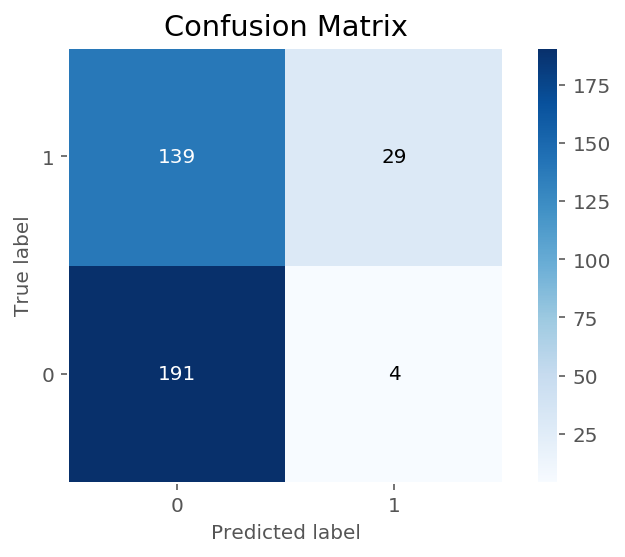

              precision    recall  f1-score   support

           0       0.58      0.98      0.73       195
           1       0.88      0.17      0.29       168

    accuracy                           0.61       363
   macro avg       0.73      0.58      0.51       363
weighted avg       0.72      0.61      0.52       363



In [414]:
skplt.metrics.plot_confusion_matrix(y_test, Y_pp.Optimise)
plt.ylim([-0.5, len(y_test.unique())-0.5])
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test,Y_pp.Optimise))

By adjusting the threshold to 0.78 the precision is now at an acceptable value- it is unlikely someone will be told they are getting a high salary when they shouldn't be. However, the trade off is that more people are going to get the impression they will get a low salary. This could be problematic as this may turn off potentially outstanding candidates as they seek a higher salary

What must be remembered is that the accuracy of my best model was 0.707 (compared to a baseline of 0.6). This model is better at predicting than just guessing, but in its current state still needs improving and optimising. This can be done by an increased sample of job adverts- either by collecting more over time as they are released, or using other websites. It may also be of use to scrape the actual job descriptions from the adverts and use an NLP process to create further predictors.

I also wanted to compare salaries between different countries, but encountered the issue that other nations aren't as proficient at listing salaries than the UK. To counter this, I intended to make a regression model to predict salaries for comparison

In [636]:
country_url={'UK':"https://www.indeed.co.uk/jobs?q=Data+%2B+Science+or+Data+%2BEngineer+or+Data+%2BArchitect+or+Data%2B+Analyst+%C2%A320000&l=%7B{}%7D&radius=10&start={}",
            'USA':"https://www.indeed.com/jobs?q=data+%2Bscientist+OR+data%2Bengineer+OR+data%2Barchitect+OR+data%2Banalyst+%2420%2C000&l={}&start={}",
            'AUS':"https://au.indeed.com/jobs?q=Data+%2B+Scientist+or+Data+%2BEngineer+or+Data+%2B+Architect+or+Data+%2BAnalyst+%2420%2C000&l={}&start={}&radius=100",
            'FR':"https://www.indeed.fr/emplois?q=Data+%2B+Scientist+or+Data+%2BEngineer+or+Data+%2B+Architect+or+Data+%2BAnalyst+20%2C000&l={}&start={}",
            'GE':"https://de.indeed.com/Jobs?q=Data+%2B+Scientist+or+Data+%2BEngineer+or+Data+%2B+Architect+or+Data+%2BAnalyst+20%2C000&l={}&radius=50",
            'CAN':"https://ca.indeed.com/jobs?q=Data+%2B+Scientist+or+Data+%2BEngineer+or+Data+%2B+Architect+or+Data+%2BAnalyst+%2420%2C000&l={}&radius=50]",
            'RSA':"https://www.indeed.co.za/jobs?q=Data+%2B+Science+or+Data+%2B+Architect++or+Data+%2B+Engineer++or+Data+%2B+Analyst&l={}&shape{}&radius=50",
            'SIN':"https://www.indeed.com.sg/jobs?q=data+%2B+science+or+data+%2B+analyst+or+data+%2B+engineer+or+data+%2B+architect&l={}&radius=50&start={}",
            'BE':"https://be.indeed.com/jobs?q=data+%2B+science+or+data+%2B+analyst+or+data+%2B+engineer&l={}&radius=50&start={}",
            'IR':"https://ie.indeed.com/jobs?q=data+%2Bscience&l={}&radius=100&start={}"}

In [665]:
country=input('Select country, choose from: UK, USA, AUS, FR, GE, CAN, RSA ')

max_city={}
cities=[]
search=True
while search==True:
    cit_in=input('Which City? ')
    cities.append(cit_in)
    if cit_in=='stop':
        search=False
cities.remove('stop')

for city in cities:
    URL=country_url[country].format(city,0)
    r = requests.get(URL)
        
    soup = BeautifulSoup(r.text, 'html.parser')

    count=[i.text.strip() for i in soup.find_all('div',attrs={'id':'searchCountPages'})]
    pattern = re.compile(r'[\S]?[\d]+')
    try:
        page=re.findall(pattern, count[0])
        if len(page)>2:
            number=page[1]+page[2]
            number=number.replace(',','').replace('.','')
            number=int(number)
        elif len(page)==2:
            number=int(page[1])
        #Limits number of searches of each city to 5000
        if number>5000:
            max_city[city]=5000
        else:
            max_city[city]=number
    except:
        max_city[city]=0
    print(city + ': ' + str(max_city[city]))

    

company=[]
salary=[]
location=[]
title=[]
sumy=[]

for city in set(cities):
    print(city + ' starting')
    for start in range(0, int(max_city[city]), 10):
        URL=country_url[country].format(city,start)
        try:
            r = requests.get(URL)
        
            soup = BeautifulSoup(r.text, 'html.parser')
            c=extract_company(soup)
            for comp in c:
                company.append(comp)
            s=extract_salary(soup)
            for sal in s:
                salary.append(sal)
            l=extract_location(soup)
            for loc in l:
                location.append(loc)
            t=extract_title(soup)
            for tit in t:
                title.append(tit)
            su=extract_summary(soup)
            for sums in su:
                sumy.append(sums)
            time.sleep(0.5)
        except:
            pass
    time.sleep(1)
    print(city + ' complete')

job_search=pd.DataFrame({'Title':title,
                         'Summary':sumy,
                         'Location':location,
                         'Company':company,
                         'Salary': salary})
    
save_name=country +'_data2.csv'
job_search.to_csv(save_name)
print('Scrape Complete')


Select country, choose from: UK, USA, AUS, FR, GE, CAN, RSA USA
Which City? New York
Which City? Philadelphia
Which City? Boston
Which City? Washington D.C
Which City? Atlanta
Which City? Miami
Which City? Orlando
Which City? New Orleans
Which City? Austin
Which City? Houston
Which City? Dallas
Which City? Las Vegas
Which City? Los Angeles
Which City? San Diego
Which City? San Francisco
Which City? Portland
Which City? Seattle
Which City? Chicago
Which City? Detroit
Which City? Denver
Which City? Kansas City
Which City? stop
New York: 5000
Philadelphia: 5000
Boston: 5000
Washington D.C: 5000
Atlanta: 5000
Miami: 5000
Orlando: 5000
New Orleans: 2517
Austin: 5000
Houston: 5000
Dallas: 5000
Las Vegas: 3333
Los Angeles: 5000
San Diego: 5000
San Francisco: 5000
Portland: 5000
Seattle: 5000
Chicago: 5000
Detroit: 5000
Denver: 5000
Kansas City: 5000
Atlanta starting
Atlanta complete
Dallas starting
Dallas complete
Denver starting
Denver complete
Kansas City starting
Kansas City complete
Seatt

In [276]:
job_search_FR=pd.read_csv('FR_data2.csv')
job_search_UK=pd.read_csv('UK_data3.csv')
job_search_USA=pd.read_csv('USA_data2.csv')
job_search_AUS=pd.read_csv('AUS_data2.csv')
job_search_GE=pd.read_csv('GE_data2.csv')
job_search_RSA=pd.read_csv('RSA_data2.csv')
job_search_SIN=pd.read_csv('SIN_data2.csv')
job_search_BE=pd.read_csv('BE_data2.csv')
job_search_CAN=pd.read_csv('CAN_data2.csv')
job_search_IR=pd.read_csv('IR_data2.csv')

In [277]:
#As different countries use different languages, the salary finder had to be adjusted accordingly
def salary_find(x,rate=1):
    moolah=[]
    if 'year' in x:
        pattern = re.compile(r'\d{1,3},\d{1,3}')
        numb=re.findall(pattern, x)
        if len(numb)>1:  
            count=0
            for i in numb:
                i=i.replace(',','')
                i=int(i)
                count+=i
            av=float(count/2)*rate
            moolah.append(av)
        else:
            dosh=numb[0].replace(',','')
            dosh=int(dosh)*rate
            moolah.append(dosh)
    elif 'month' in x:
        pattern=re.compile(r'\d{1,3},\d{1,3}')
        num=re.findall(pattern,x)
        num=num[0].replace(',','')
        num=int(num)*rate*12
        moolah.append(num)
        
    else:
        moolah.append(np.nan)
    return moolah
def salary_find_france(x,rate=1):
    moolah=[]
    if 'an' in x:
        try:
            pattern = re.compile(r'\d{2}\s\d{3}')
            numb=re.findall(pattern, x)
            if len(numb)>1:  
                count=0
                for i in numb:
                    i=i.replace('\xa0','')
                    i=int(i)
                    count+=i
                av=float(count/2)*rate
                moolah.append(av)
            else:
                dosh=numb[0].replace('\xa0','')
                dosh=int(dosh)*rate
                moolah.append(dosh)
        except:
            moolah.append(np.nan)
    elif 'mois' in x:
        pattern=re.compile(r'\d.\d{2,3}|\d{3}')
        num=re.findall(pattern,x)
        num=num[0].replace('\xa0','')
        num=int(num)*12*rate
        moolah.append(num)
            
        
    else:
        moolah.append(np.nan)
    
    return moolah
def salary_find_rand(x,rate=1):
    moolah=[]
    if 'year' in x:
        try:
            pattern = re.compile(r'\d{1,3}\s\d{3}')
            numb=re.findall(pattern, x)
            if len(numb)>1:  
                count=0
                for i in numb:
                    i=i.replace('\xa0','')
                    i=int(i)
                    count+=i
                av=float(count/2)*rate
                moolah.append(av)
            else:
                dosh=numb[0].replace('\xa0','')
                dosh=int(dosh)*rate
                moolah.append(dosh)
        except:
            moolah.append(np.nan)
    elif 'month' in x:
        pattern=re.compile(r'\d{1,3}\s\d{3}')
        num=re.findall(pattern,x)
        if len(num)==2:
            num=num[0].replace('\xa0','')
            num=int(num)*12*rate
            moolah.append(num)
        elif len(num)>2:
            count=0
            for i in numb:
                i=i.replace('\xa0','')
                i=int(i)
                count+=i
            av=float(count/2)*rate*12
            moolah.append(av)         
        
    else:
        moolah.append(np.nan)
    
    return moolah
def salary_find_ger(x,rate=1):
    moolah=[]
    if 'Jahr' in x or 'jaar' in x:
        pattern = re.compile(r'\d{1,2}.\d{1,3}')
        numb=re.findall(pattern, x)
        if len(numb)>1:  
            count=0
            for i in numb:
                i=i.replace('.','')
                i=int(i)
                count+=i
            av=float(count/2)*rate
            moolah.append(av)
        else:
            dosh=numb[0].replace('.','')
            dosh=int(dosh)*rate
            moolah.append(dosh)
    elif 'Monat' in x or 'maand' in x:
        pattern=re.compile(r'\d{1,2}.\d{1,3}')
        num=re.findall(pattern,x)
        num=num[0].replace('.','')
        num=int(num)*rate*12
        moolah.append(num)
        
    else:
        moolah.append(np.nan)
    return moolah

In [278]:
countries=['FR','AUS','UK','USA','RSA','GE','SIN','BE','CAN','IR']
ctry={'FR':'France','AUS':'Australia','UK':'United Kingdom','USA':'USA','RSA':'South Africa','GE':'Germany','SIN':'Singapore','BE':'Belgium','CAN':'Canada','IR':'Ireland'}
searches={'FR':job_search_FR,'AUS':job_search_AUS,'UK':job_search_UK,'USA':job_search_USA,'RSA':job_search_RSA,'GE':job_search_GE, 'SIN':job_search_SIN,'BE':job_search_BE,'CAN':job_search_CAN,'IR':job_search_IR}
exchange_rate={'UK':1,'USA':0.77,'AUS':0.53,'FR':0.85,'RSA':0.053,'GE':0.85,'SIN':0.57,'BE':0.85,'CAN':0.59,'IR':0.85}

In [279]:
#Loops through countries to calculate mean and median salaries
mn=[]
mdn=[]
ct=[]
hs=[]
an=[]
nation=[]
for i in countries:
    search=searches[i]
    search['Country']=ctry[i]
    nation.append(ctry[i])
    search.Location.fillna(inplace=True,method='backfill')
    search.dropna(inplace=True)
    search.drop_duplicates(keep='first',inplace=True,subset=['Title','Location','Company'])
    search.reset_index(drop=True,inplace=True)
    if 'Unnamed: 0' in search.columns:
        search.drop('Unnamed: 0',axis=1,inplace=True)
    if i=='FR':
        search['Sal']=search.Salary.apply(salary_find_france,rate=exchange_rate[i]).str[0]
    elif i=='RSA':
        search['Sal']=search.Salary.apply(salary_find_rand,rate=exchange_rate[i]).str[0]
    elif i=='GE' or i =='BE':
        search['Sal']=search.Salary.apply(salary_find_ger,rate=exchange_rate[i]).str[0]
    else:
        search['Sal']=search.Salary.apply(salary_find,rate=exchange_rate[i]).str[0]
    search.dropna(inplace=True)
    search.reset_index(drop=True,inplace=True)
    mn.append(round(search.Sal.mean(),0))
    median=search.Sal.median()
    mdn.append(round(median,0))
    count=len(search.Sal)
    ct.append(count)
    
country_df=pd.DataFrame({'Country':nation,
                         'Mean Salary':mn,
                         'Median Salary':mdn,
                         'Number of Hits':ct
                         })

In [280]:
country_df

,Country,Mean Salary,Median Salary,Number of Hits
0,France,24750.0,22950.0,1419
1,Australia,55121.0,53000.0,289
2,United Kingdom,37297.0,35000.0,1815
3,USA,52728.0,49902.0,1003
4,South Africa,14151.0,11925.0,10
5,Germany,20810.0,20344.0,14
6,Singapore,49062.0,47025.0,81
7,Belgium,37901.0,42500.0,12
8,Canada,44706.0,41141.0,15
9,Ireland,49020.0,46750.0,121


As you can see, there is some differences between the countries, but only France, UK and USA can reasonably be compared due to their actual collection numbers. A regression model is performed below to predict other salaries.

In [281]:
dfs=[job_search_UK,job_search_AUS,job_search_BE,job_search_CAN,job_search_FR,job_search_GE,job_search_IR,job_search_RSA,job_search_SIN,job_search_USA]
regress_df=pd.concat(dfs)

In [291]:
#regress_df=pd.get_dummies(regress_df,columns=['Country'],drop_first=True)
regress_df['entry_job']=regress_df.Title.apply(job_dummy,job_type=entry_job).str[0]
regress_df['senior_job']=regress_df.Title.apply(job_dummy,job_type=senior_job).str[0]
regress_df['temp_job']=regress_df.Title.apply(job_dummy,job_type=temp_job).str[0]
regress_df=pd.get_dummies(regress_df,columns=['Country'],drop_first=True)

In [292]:
regress_df['smaller_sal']=regress_df.Sal.apply(lambda x: x/1000)

In [293]:
y=regress_df[['smaller_sal']]
X=regress_df.drop(['Company','Salary','Location','Sal','Title',"Sal"],axis=1)

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,train_size=0.8)

In [295]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(token_pattern='\w+',binary=True,ngram_range=(1,2),stop_words=['english','french','german'],min_df=0.005,lowercase=True)
cvec.fit(X_train.Summary)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.005,
                ngram_range=(1, 2), preprocessor=None,
                stop_words=['english', 'french', 'german'], strip_accents=None,
                token_pattern='\\w+', tokenizer=None, vocabulary=None)

In [296]:
df_train = pd.DataFrame(cvec.transform(X_train.Summary).toarray(),
                  columns=cvec.get_feature_names())
df_test = pd.DataFrame(cvec.transform(X_test.Summary).toarray(),
                  columns=cvec.get_feature_names())

In [297]:
X_test.reset_index(inplace=True,drop=True)

In [298]:
train=pd.merge(X_train.drop('Summary',axis=1),df_train,left_index=True,right_index=True)
test=pd.merge(X_test.drop('Summary',axis=1),df_test,left_index=True,right_index=True)

In [299]:
from sklearn.linear_model import ElasticNetCV

In [244]:
p={'l1_ratio':[0.01,0.1,0.5,0.9,0.99],
   'n_alphas':[1,10,100,1000],
   'max_iter':[10,100,1000]}
model=ElasticNetCV()

In [245]:
grid_EN=GridSearchCV(model,
                     p,
                     n_jobs=-1, 
                  cv=5, 
                  verbose=1, 
                  return_train_score=True).fit(train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 56.5min finished
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [246]:
grid_EN.best_estimator_.score(test,y_test)

0.004346668687235211

Unfortuantely, the R2 indicates my regression is barely better than guessing the mean. Therefore, it is not useful for predicting salaries and this enterprise must be abandoned. Again, more data and predictors and a reliable transalting api may have improved this model.

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [14]:
## See above

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [15]:
## See above

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [16]:
## See above

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

Can information from job adverts be used to predict whether a salary will be high or low? By using information obtained from www.indeed.co.uk and using a Logistic Regression model with a Bagging Classifier, it was found that salaries could be predicted with an accuracy of 70.8%.

Information required was collected from www.indeed.co.uk using the Python package BeautifulSoup which enables data scientists to extract information from a website in a timely and efficient manner. By including a variety of UK cities (seen in the table below) and a search radius of 10 miles, 1815 job adverts which listed annual or monthly salaries were identified for analysis. 

For the purpose of this investigation, a salary greater than £35000 was considered as a high salary. This was found by comparing all UK annual salaries and identifying the median value. In other words, listing all salries in order from smallest to largest, £35000 was the value found to be in the middle.

To be able to predict a salaries category, a list of predictors is needed. Initially this consisted of using the jobs location and whether the job advert listed if it was a senior, or junior role. This was expanded on by using common words found in the job descriptions to further enhance the search. 

With the predictors identified, it was time to investigate several models to see which would produce the highest accuracy in predicting if a job would be high paying or not. As a category was being predicted, it was essential that a classification model was used. After comparing and contrasting several, it was found that a Logistic Regression model, enhanced with a Bagging ensemble method produced the highest prediction accuracy. I won't delve into too much detail how these models work, as it shall suffice to say that this model correctly predicted a job's salary 70.8% of the time. This is to be compared to a lower salary of 60% of just guessing what category a salary would fall in. 

While this model produces an accuracy that is better than guessing, it is still far from the finished article. I would suggest that collecting more job adverts from more cities would lead to a better model. 

A criteria placed upon this investigation was that the model was to minimise the chance of incorrectly informing someone they had a high paying job. To account for this, I adjusted the model so that the threshold of where it split the categories was increased from 50% to 78%. This resulted in the model correctly informing high paying candiates 88% of the time. However, the consequence of this was that the model incorrectly misidentified higher paying jobs as low. In fact, a high paying job was only correctly identified 17% of the time. 

Therefore, this investigation has produced a model which predicts whether a job is high paying or not with an accuracy of 70.8%. However, predictions must be treated with a degree of skepticisim as the model is inclined to incorrectly inform high paying jobs as low. 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

https://www.onlineescaperooms.co.uk/post/can-you-predict-a-data-scientists-salary